## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [2]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.1]
redice_lr_patient = [5,10,15]

In [11]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W1211 21:23:04.373874 19436 deprecation_wrapper.py:119] From C:\Users\jcodeboy\Anaconda3\envs\tensorflow-GPU\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1211 21:23:04.377864 19436 deprecation_wrapper.py:119] From C:\Users\jcodeboy\Anaconda3\envs\tensorflow-GPU\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1211 21:23:04.381396 19436 deprecation_wrapper.py:119] From C:\Users\jcodeboy\Anaconda3\envs\tensorflow-GPU\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1211 21:23:04.460151 19436 deprecation_wrapper.py:119] From C:\Users\jcodeboy\Anaconda3\envs\tensorflow-GPU\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W1211 21:23:04.614737 19436 deprecation_wrapper.py:119] From C:\Users\jcodeboy\Anaconda3\envs\tensorflow-GPU\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1211 21:23:04.620722 19436 deprecation_wrapper.py:119] From C:\Users\jcodeboy\Anaconda3\envs\tensorflow-GPU\lib\site-packages\keras\backend\tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.

W1211 21:23:04.694525 19436 deprecation.py:323] From C:\Users\jcodeboy\Anaconda3\envs\tensorflow-GPU\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024

Epoch 14/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.2387 - acc: 0.5709 - val_loss: 1.4782 - val_acc: 0.4803
Epoch 15/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.2154 - acc: 0.5800 - val_loss: 1.4695 - val_acc: 0.4875
Epoch 16/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1961 - acc: 0.5864 - val_loss: 1.4776 - val_acc: 0.4842
Epoch 17/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.1764 - acc: 0.5949 - val_loss: 1.4585 - val_acc: 0.4911
Epoch 18/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.1574 - acc: 0.6019 - val_loss: 1.4584 - val_acc: 0.4886
Epoch 19/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.1376 - acc: 0.6088 - val_loss: 1.4532 - val_acc: 0.4898
Epoch 20/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.1211 - acc: 0.6137 - val_loss: 1.4529 - val_acc: 0.4922
Epoch 21/25
50000/50000 [=========

50000/50000 [==============================] - 2s 47us/step - loss: 2.2022 - acc: 0.2707 - val_loss: 2.1343 - val_acc: 0.2988
Epoch 2/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.7456 - acc: 0.3897 - val_loss: 1.8360 - val_acc: 0.3813
Epoch 3/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.6203 - acc: 0.4312 - val_loss: 1.6883 - val_acc: 0.4167
Epoch 4/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.5425 - acc: 0.4610 - val_loss: 1.6293 - val_acc: 0.4406
Epoch 5/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4905 - acc: 0.4784 - val_loss: 1.5958 - val_acc: 0.4449
Epoch 6/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4481 - acc: 0.4959 - val_loss: 1.5621 - val_acc: 0.4567
Epoch 7/25
50000/50000 [==============================] - 2s 30us/step - loss: 1.4117 - acc: 0.5070 - val_loss: 1.5390 - val_acc: 0.4644
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 31us/step - loss: 1.0418 - acc: 0.6442 - val_loss: 1.4486 - val_acc: 0.4985
Epoch 25/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.0242 - acc: 0.6515 - val_loss: 1.4323 - val_acc: 0.5047
Numbers of exp: 5, reduce_factor: 0.10, reduce_patient: 15
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________


50000/50000 [==============================] - 2s 31us/step - loss: 0.9128 - acc: 0.6830 - val_loss: 2.0506 - val_acc: 0.3968
Epoch 12/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.8742 - acc: 0.6960 - val_loss: 1.6677 - val_acc: 0.4590

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 13/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.7591 - acc: 0.7436 - val_loss: 1.3917 - val_acc: 0.5272
Epoch 14/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.7109 - acc: 0.7618 - val_loss: 1.4928 - val_acc: 0.4995
Epoch 15/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.6764 - acc: 0.7743 - val_loss: 1.5104 - val_acc: 0.4941
Epoch 16/25
50000/50000 [==============================] - 2s 31us/step - loss: 0.6433 - acc: 0.7889 - val_loss: 1.6089 - val_acc: 0.4718
Epoch 17/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.6160 - acc: 0.7988 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.8982 - acc: 0.3517 - val_loss: 1.9703 - val_acc: 0.3444
Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5514 - acc: 0.4566 - val_loss: 1.6990 - val_acc: 0.4156
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.4551 - acc: 0.4902 - val_loss: 1.6863 - val_acc: 0.4142
Epoch 4/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3897 - acc: 0.5141 - val_loss: 1.5649 - val_acc: 0.4500
Epoch 5/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.3362 - acc: 0.5345 - val_loss: 1.5903 - val_acc: 0.4450
Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2916 - acc: 0.5500 - val_loss: 1.4896 - val_acc: 0.4764
Epoch 7/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2517 - acc: 0.5646 - val_loss: 1.4898 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 0.8773 - acc: 0.7107 - val_loss: 1.3657 - val_acc: 0.5243
Epoch 24/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.8684 - acc: 0.7147 - val_loss: 1.3661 - val_acc: 0.5260
Epoch 25/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.8666 - acc: 0.7171 - val_loss: 1.3681 - val_acc: 0.5255
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 10
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
__________________________________________________________

50000/50000 [==============================] - 2s 32us/step - loss: 1.6217 - acc: 0.4358 - val_loss: 1.7138 - val_acc: 0.4006
Epoch 11/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6057 - acc: 0.4414 - val_loss: 1.7020 - val_acc: 0.4012
Epoch 12/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5905 - acc: 0.4472 - val_loss: 1.6928 - val_acc: 0.4052
Epoch 13/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5774 - acc: 0.4500 - val_loss: 1.6847 - val_acc: 0.4095
Epoch 14/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5646 - acc: 0.4556 - val_loss: 1.6771 - val_acc: 0.4115
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5534 - acc: 0.4599 - val_loss: 1.6702 - val_acc: 0.4125
Epoch 16/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5430 - acc: 0.4635 - val_loss: 1.6641 - val_acc: 0.4104
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.8622 - acc: 0.3621 - val_loss: 2.7270 - val_acc: 0.2468
Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5559 - acc: 0.4568 - val_loss: 1.9625 - val_acc: 0.3385
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.4442 - acc: 0.4936 - val_loss: 1.7168 - val_acc: 0.3967
Epoch 4/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3616 - acc: 0.5240 - val_loss: 2.0320 - val_acc: 0.3418
Epoch 5/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3024 - acc: 0.5455 - val_loss: 1.6726 - val_acc: 0.4074
Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2495 - acc: 0.5663 - val_loss: 1.5325 - val_acc: 0.4649
Epoch 7/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.1987 - acc: 0.5838 - val_loss: 1.7884 - val_acc

50000/50000 [==============================] - 2s 32us/step - loss: 0.8709 - acc: 0.7099 - val_loss: 1.5748 - val_acc: 0.4717
Epoch 24/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.8505 - acc: 0.7160 - val_loss: 1.6523 - val_acc: 0.4607
Epoch 25/25
50000/50000 [==============================] - 2s 32us/step - loss: 0.8318 - acc: 0.7214 - val_loss: 1.5345 - val_acc: 0.4740
Numbers of exp: 15, reduce_factor: 0.10, reduce_patient: 5
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
___________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6740 - acc: 0.4162 - val_loss: 1.7531 - val_acc: 0.3923
Epoch 11/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6484 - acc: 0.4240 - val_loss: 1.7373 - val_acc: 0.4017
Epoch 12/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6263 - acc: 0.4308 - val_loss: 1.7124 - val_acc: 0.4106
Epoch 13/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6045 - acc: 0.4418 - val_loss: 1.7005 - val_acc: 0.4122
Epoch 14/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5859 - acc: 0.4454 - val_loss: 1.6879 - val_acc: 0.4168
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5671 - acc: 0.4517 - val_loss: 1.6733 - val_acc: 0.4208
Epoch 16/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5512 - acc: 0.4569 - val_loss: 1.6683 - val_acc: 0.4211
Epoch 17/25
50000/50000 [=========

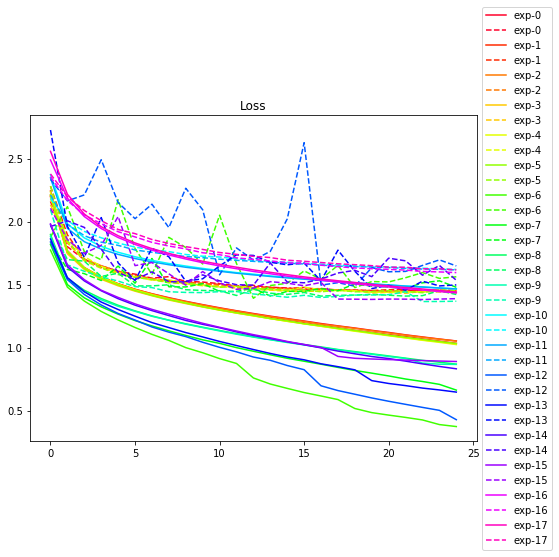

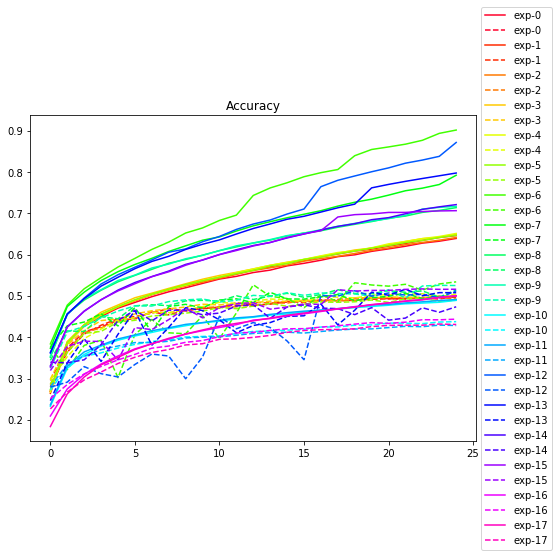

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()